## PCA e Visualização de Clusters

Análise de Componentes Principais (PCA) para reduzir a dimensionalidade dos dados e visualizar os clusters identificados no espaço tridimensional, facilitando a interpretação dos resultados.

In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "1" #evitar o warning do kmeans
import joblib


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.colors import ListedColormap

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder, 
    MinMaxScaler, 
    OneHotEncoder, 
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

from src.config import (
    DADOS_LIMPOS, 
    DADOS_CLUSTERED, 
    DADOS_PCA_SCALED,
    MODELO_PCA, 
   
)
from src.graficos import graficos_elbow_silhouette, visualizar_clusters
from src.models import RANDOM_STATE
from src.models import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
)

sns.set_theme(palette='tab10')

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [4]:
# Agrupamento das colunas de acordo com o pré-processamebto necessário
colunas_numericas = list(df.select_dtypes("number").columns)
coluna_categorica = ["Gender"]
colunas_numericas


['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

Fluxo da Análise:
1. Pré-processamento dos Dados:
Transformação de Variáveis:

Variáveis categóricas (Gender) são codificadas via OneHotEncoder

Variáveis numéricas são transformadas usando PowerTransformer para normalizar distribuições

Normalização: Essencial para algoritmos baseados em distâncias como K-Means

In [5]:
# Preprocessamento
preprocessamento = ColumnTransformer(
    [
        ("one_hot", OneHotEncoder(drop='first'), coluna_categorica),  #"first"
        ("PowerTransformer", PowerTransformer(), colunas_numericas),     
        
    ]
)



2. Pipeline

Redução de dimensionalidade:

PCA com 3 componentes principais para visualização 3D

Clustering:

K-Means com 5 clusters (consistente com a análise anterior)

In [6]:
# Pipeline
#PCA com 3 componentes para ajudar a visualização
pipeline = Pipeline([
    ('preprocessamento', preprocessamento),
    ("pca", PCA(n_components=3, random_state=RANDOM_STATE)),
    ('kmeans', KMeans(n_clusters=5, random_state=42, n_init=10)) 
])

In [7]:
pipeline.fit(df)

Pipeline(steps=[('preprocessamento',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender']),
                                                 ('PowerTransformer',
                                                  PowerTransformer(),
                                                  ['Age', 'Annual Income (k$)',
                                                   'Spending Score '
                                                   '(1-100)'])])),
                ('pca', PCA(n_components=3, random_state=42)),
                ('kmeans', KMeans(n_clusters=5, n_init=10, random_state=42))])

In [8]:
joblib.dump(pipeline, MODELO_PCA)

['D:\\ciencias_dados\\python_pratica\\hashtag\\ciencias_dados\\machine_learning\\projeto_clustering_clientes_supermercado\\modelos\\modelo_pca_clustering.pkl']

In [9]:
# criar dataframe com os dados preprocessados
df_scaled = pd.DataFrame(
    preprocessamento.fit_transform(df),
    columns= preprocessamento.get_feature_names_out(),
)


In [10]:
df_scaled.head()

,one_hot__Gender_Male,PowerTransformer__Age,PowerTransformer__Annual Income (k$),PowerTransformer__Spending Score (1-100)
0,1.0,-1.718993,-1.989930,-0.385308
1,1.0,-1.470002,-1.989930,1.164467
2,0.0,-1.591912,-1.930366,-1.820424
3,0.0,-1.240020,-1.930366,1.023549
4,0.0,-0.461118,-1.872032,-0.346103


In [28]:
#adicionar a coluna 'cluster'
df_scaled['Cluster'] = pipeline.named_steps['kmeans'].labels_
df_scaled.to_parquet(DADOS_PCA_SCALED, index=False)
df_scaled.head()

,one_hot__Gender_Male,PowerTransformer__Age,PowerTransformer__Annual Income (k$),PowerTransformer__Spending Score (1-100),Cluster
0,1.0,-1.718993,-1.989930,-0.385308,0
1,1.0,-1.470002,-1.989930,1.164467,0
2,0.0,-1.591912,-1.930366,-1.820424,2
3,0.0,-1.240020,-1.930366,1.023549,0
4,0.0,-0.461118,-1.872032,-0.346103,2


In [12]:
#para visualizar os dados originais clusterizados
df_clustered = df.copy()
df_clustered['Cluster'] = pipeline.named_steps['kmeans'].labels_
df_clustered.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,Male,19,15,39,0
1,Male,21,15,81,0
2,Female,20,16,6,2
3,Female,23,16,77,0
4,Female,31,17,40,2


In [13]:
colunas_plot =colunas_numericas + ['Cluster']
colunas_plot

['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Cluster']

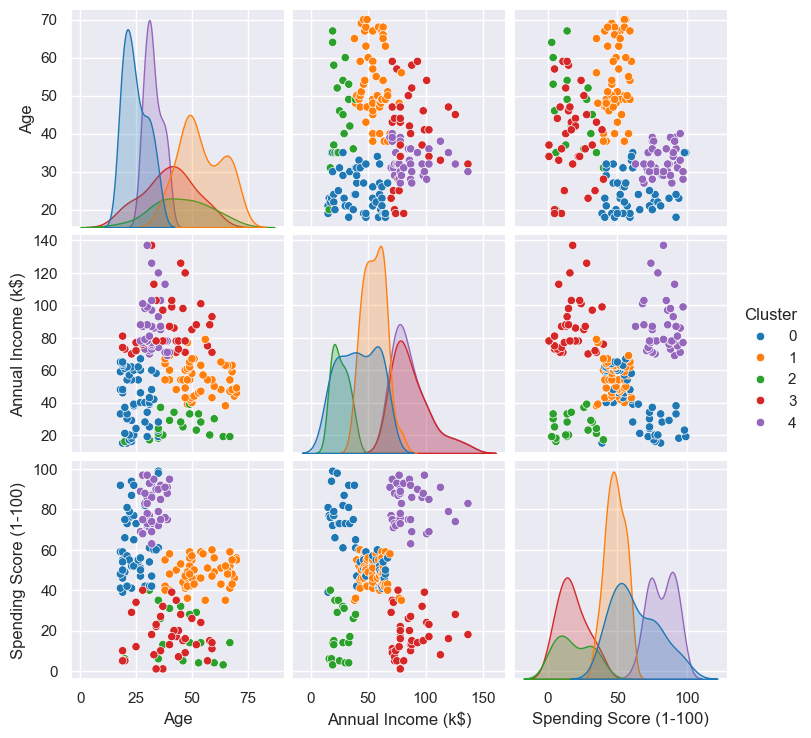

In [14]:
# Criar o pairplot visualizando a distribuição dos clusters. 

sns.pairplot(df_clustered[colunas_plot], diag_kind='kde', hue='Cluster', palette='tab10')
plt.show()

In [15]:
#O gráfico acima ajuda a entender a distribuição dos clusters, mas como o gráfico 2d, os clusters podem parecer coincidentes, mesmo não sendo.

Boxplots por cluster:

Comparar distribuições de cada variável numérica entre clusters

Mostrar as médias (triângulos) e dispersão dos dados

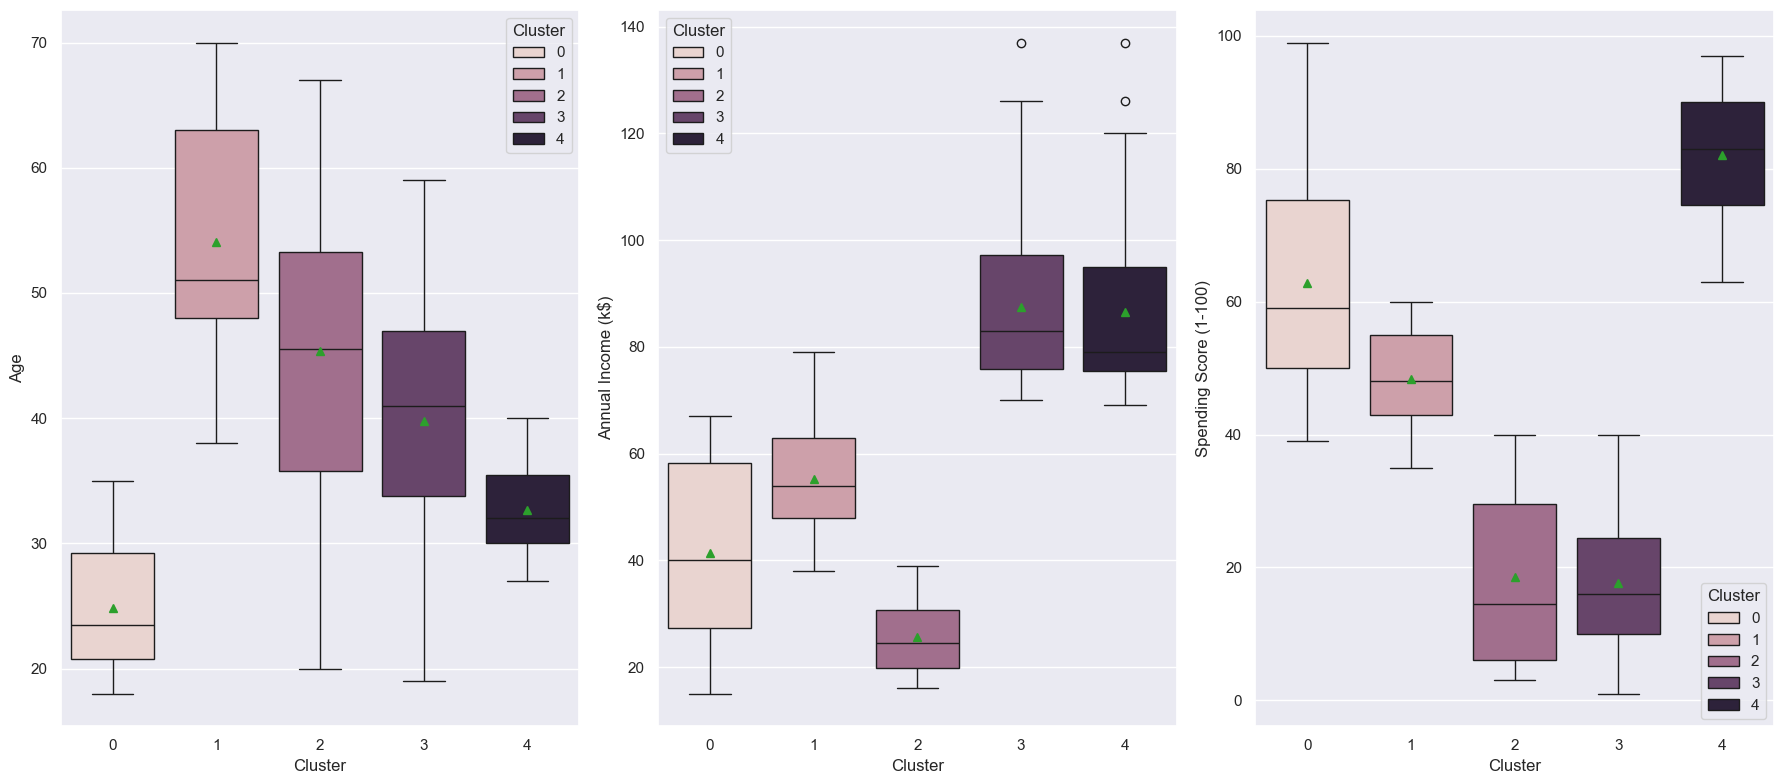

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(18, 8))
for ax, coluna in zip(axs.flatten(), df_clustered[colunas_plot]):
    sns.boxplot(y=coluna, ax=ax, data=df_clustered[colunas_plot], showmeans=True, x="Cluster", hue="Cluster")

plt.tight_layout()
plt.show()

- Cluster 0 - Pontuação de gastos altos, renda moderada-baixa, jovens 
- Cluster 1 - Pontuação de gastos moderados, renda moderada, idade alta
- Cluster 2 - Pontuação de gastos baixos, renda baixa, idade moderada
- Cluster 3 - Pontuação de gastos baixos, renda alta, moderada
- Cluster 4 - Pontuação de gastos altos, renda alta, jovens adultos 

transformando os pontos acima em uma tabela:

Pontuação de gastos | Renda | Idade | Número Cluster
--- | --- | --- | ---
Altos | Moderada-baixa | Jovens | 0
Moderados | Moderada | Alta | 1
Baixos | Baixos | Moderada | 2
Baixos | Alta | Moderada | 3
Altos | Altos | Jovens Adultos | 4


In [17]:
#tamanho de cada cluster
df_clustered["Cluster"].value_counts(normalize=True).mul(100).sort_index()

Cluster
0    26.0
1    26.5
2    10.0
3    18.0
4    19.5
Name: proportion, dtype: float64

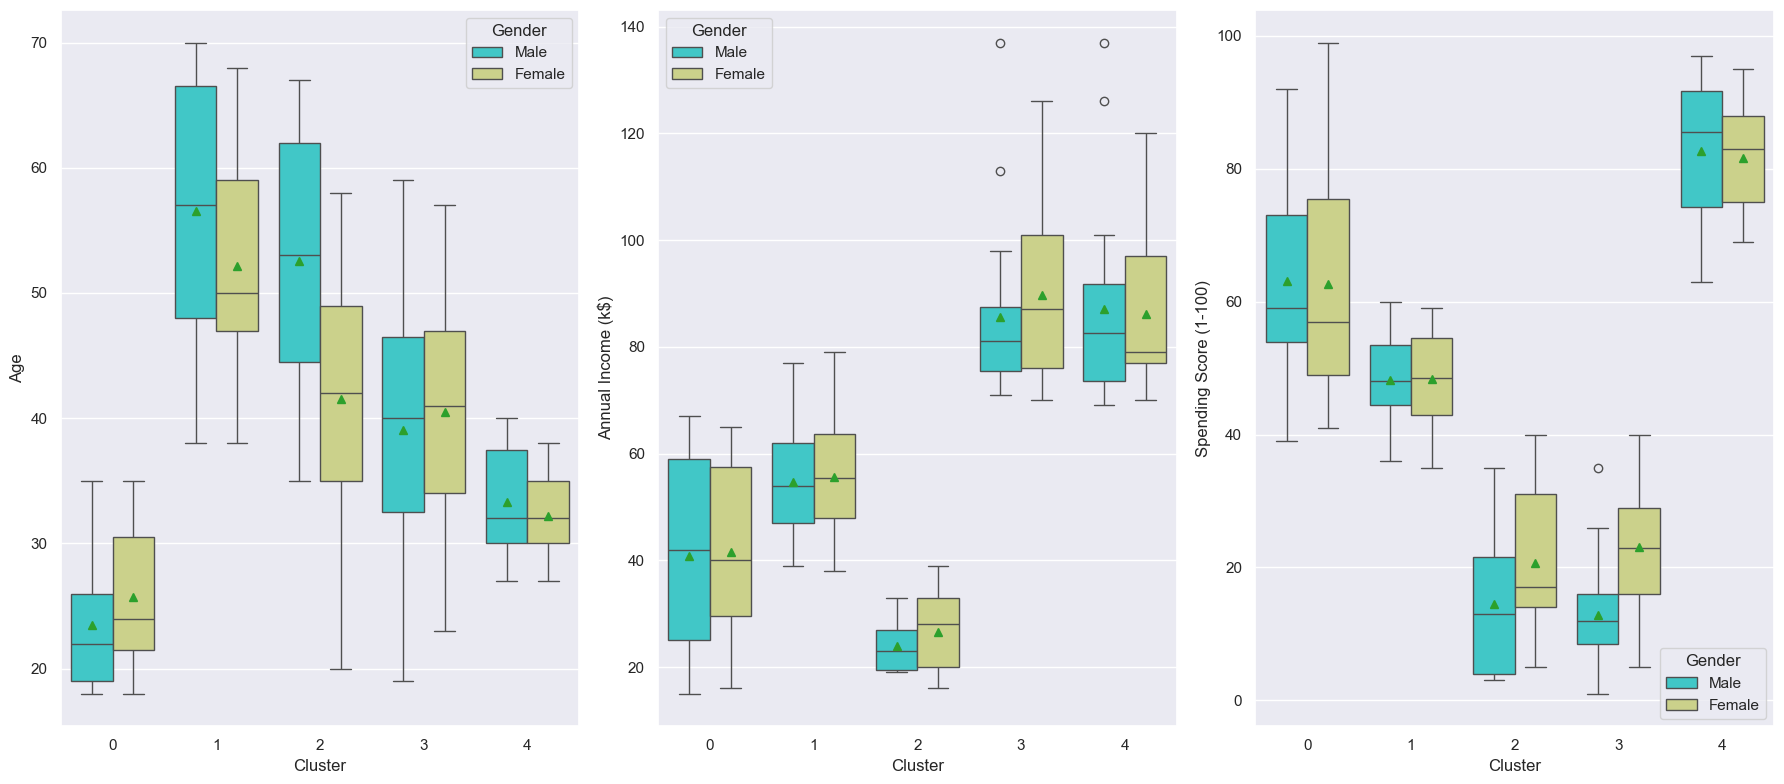

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(18, 8))
for ax, coluna in zip(axs.flatten(), df_clustered.select_dtypes("number").columns):
    sns.boxplot(y=coluna, ax=ax, data=df_clustered, showmeans=True, x="Cluster", hue="Gender", palette='rainbow')

plt.tight_layout()
plt.show()

In [19]:
#composição de cada cluster considerando a composição por gênero
df_clustered.groupby(by=["Cluster", "Gender"]).size()

Cluster  Gender
0        Female    31
         Male      21
1        Female    30
         Male      23
2        Female    13
         Male       7
3        Female    17
         Male      19
4        Female    21
         Male      18
dtype: int64

In [20]:
#dados para construção do gráfico 3d
pipeline['pca'].get_feature_names_out()

array(['pca0', 'pca1', 'pca2'], dtype=object)

In [21]:
pipeline['kmeans'].cluster_centers_

array([[-1.2027974 , -0.6593989 , -0.32799851],
       [ 0.74582801, -0.12475351,  0.74077638],
       [ 1.07296581, -1.60915556, -0.33896871],
       [ 1.0909522 ,  0.77802646, -0.94516854],
       [-0.96710295,  1.15576507,  0.47692861]])

In [22]:
# criar dataframe com os dados preprocessados
df_pca = pd.DataFrame(
    pipeline[:-1].fit_transform(df),
    columns= pipeline[:-1].get_feature_names_out(),
)
df_pca['Cluster'] = pipeline.named_steps['kmeans'].labels_


In [23]:
df_pca.head()

,pca0,pca1,pca2,Cluster
0,-1.142896,-2.029633,-1.252916,0
1,-2.048545,-1.767850,0.000318,0
2,-0.080170,-2.238019,-2.134130,2
3,-1.816368,-1.758877,0.091394,0
4,-0.303412,-1.920839,-0.317087,2


In [24]:
print("Shape dos centróides:",  pipeline.named_steps['kmeans'].cluster_centers_.shape) 


Shape dos centróides: (5, 3)


In [25]:
centroids = pipeline['kmeans'].cluster_centers_[: , 0:3]
centroids


array([[-1.2027974 , -0.6593989 , -0.32799851],
       [ 0.74582801, -0.12475351,  0.74077638],
       [ 1.07296581, -1.60915556, -0.33896871],
       [ 1.0909522 ,  0.77802646, -0.94516854],
       [-0.96710295,  1.15576507,  0.47692861]])

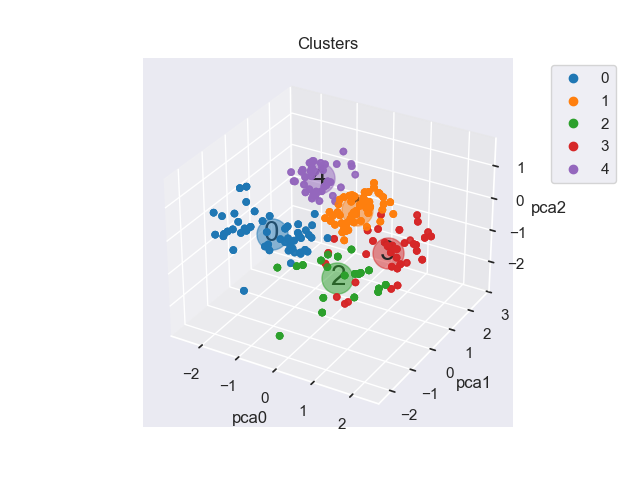

In [26]:
%matplotlib ipympl

visualizar_clusters(
    dataframe = df_pca,
    colunas= ['pca0', 'pca1', 'pca2'], 
    quantidade_cores=5, 
    centroids=centroids,
    mostrar_centroids=True, 
    coluna_clusters = df_scaled['Cluster'],
    mostrar_pontos=True
)

## Conclusão - PCA e Visualização 3D

A redução de dimensionalidade com PCA permitiu:

Visualização eficiente: Os 3 componentes principais capturaram a essência dos dados (sugerido pela variância explicada).

Confirmação dos clusters: A projeção 3D mostrou grupos bem separados, validando a escolha de 5 clusters.

Vantagens:

A técnica simplificou a comunicação dos resultados para stakeholders não técnicos.

Facilitou a identificação de outliers e sobreposições entre clusters.

Recomendação final:
Combinar as análises dos 3 notebooks permite criar personas de clientes e desenvolver estratégias baseadas em dados concretos.